# Fairness in Recidvisim Risk Scores

adapted from [BPDM 2017 Tutorial by Caitlin Kuhlman et al](https://github.com/caitlinkuhlman/bpdmtutorial)

__Tools:__ Analysis will be done in python, using a number of open source packages commonly used for data science tasks:
- __Numpy__ scientific computing. http://www.numpy.org/
- __Pandas__ data analysis and manipulation http://pandas.pydata.org/
- __Scikit-learn__ machine learning http://scikit-learn.org/stable/
- __Matplotlib__ plotting https://matplotlib.org/

__Material:__ *Disclaimer*: The analysis presented here is directly inspired by the following references:

[1] ProPublica, *“Machine Bias,”* https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing, May 2016.

[2] A. Chouldechova. *"Fair prediction with disparate impact: A study of bias in recidivism prediction instruments."* arXiv preprint arXiv:1703.00056 (2017).

[3] F. P. Calmon, D. Wei, K. Natesan Ramamurthy, and K. R. Varshney, *“Optimized Data Pre- Processing for Discrimination Prevention,”* arXiv preprint arXiv:1704.03354 (2017)

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import roc_curve
%matplotlib inline
sns.set(font_scale=1.5)

# Data prep

Import the COMPAS dataset.

In [3]:
DATA_FOLDER = 'data/'

df = pd.read_csv(
    DATA_FOLDER + 'compas-scores-two-years.csv',
    index_col=0)

# df = pd.read_csv("https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv", header=0).set_index('id')

First, let's take a look at this dataset. We print the list of varialbe names, or features, and then the first 5 rows.

In [4]:
print(list(df))
df.head()

['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']


,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
id,,,,,,,,,,,,,,,,,,,,,
1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


For this analysis, we will restrict ourselves to only a few features, given below.

In [5]:
# Select features that will be analyzed
df = df[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
df.head()

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
id,,,,,,,,,,,,,
1,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20
3,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1,2013-01-26 03:45:27,2013-02-05 05:36:53
4,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1,2013-04-13 04:58:34,2013-04-14 07:02:04
5,23,F,African-American,Less than 25,High,Male,1,NaN,8,0,0,NaN,NaN
6,43,F,Other,25 - 45,Low,Male,2,NaN,1,0,0,NaN,NaN


Notice that there are some negative entries. Below is the description of the cleanup of this dataset done in the ProPublica analysis. In the original notebook the authors state:

> There are a number of reasons remove rows because of missing data:
> * If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
> * We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
> * In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
> * We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

We repeat this filtering below.

In [6]:
# ix is the index of variables we want to keep.

# Remove entries with inconsistent arrest information.
ix = df['days_b_screening_arrest'] <= 30
ix = (df['days_b_screening_arrest'] >= -30) & ix

# remove entries entries where compas case could not be found.
ix = (df['is_recid'] != -1) & ix

# remove traffic offenses.
ix = (df['c_charge_degree'] != "O") & ix

# remove entries without available text scores.
ix = (df['score_text'] != 'N/A') & ix

# trim dataset
df = df.loc[ix,:]

# create new attribute "length of stay" with total jail time.
df['length_of_stay'] = (pd.to_datetime(df['c_jail_out'])-pd.to_datetime(df['c_jail_in'])).apply(lambda x: x.days)

# print number of rows
print('Number of rows : '+str(len(df)))
# print list of features again
print('Features: '+str(list(df)))

Number of rows : 6172
Features: ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'length_of_stay']


In [ ]:
df.to_csv('data/compas-scores-two-years-clean.csv')

Here is an explanation of these features:

* `age`: defendant's age
* `c_charge_degree`: degree charged (Misdemeanor of Felony)
* `race`: defendant's race
* `age_cat`: defendant's age quantized in "less than 25", "25-45", or "over 45"
* `score_text`: COMPAS score: 'low'(1 to 5), 'medium' (5 to 7), and 'high' (8 to 10).
* `sex`: defendant's gender
* `priors_count`: number of prior charges
* `days_b_screening_arrest`: number of days between charge date and arrest where defendant was screened for compas score
* `decile_score`: COMPAS score from 1 to 10
* `is_recid`: if the defendant recidivized
* `two_year_recid`: if the defendant within two years
* `c_jail_in`: date defendant was imprisoned
* `c_jail_out`: date defendant was released from jail
* `length_of_stay`: length of jail stay

Next we look at the number of entries for each race.

In [28]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

We restrict our analysis to African-American and Caucasian, since we have significantly more samples for these two groups. We remove entries not marked as African-American or Caucasian, and look at the distribution of COMPAS scores.

In [29]:
df = df.loc[df['race'].isin(['African-American','Caucasian'])]

## COMPAS score distribution

Let's look at the COMPAS score distribution between African-Americans and Caucasians (matches the one in the ProPublica article).

In [30]:
table = df.groupby(['race','decile_score']).size().reset_index().pivot(index='decile_score',columns='race',values=0)

# percentage of defendants in each score category
100*table/table.sum()

race,African-American,Caucasian
decile_score,,
1,11.496063,28.768426
2,10.897638,15.263909
3,9.385827,11.317166
4,10.614173,11.554922
5,10.173228,9.510223
6,10.015748,7.608179
7,10.803150,5.373276
8,9.480315,4.564907
9,9.984252,3.661436


/home/smb/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Fraction of population')

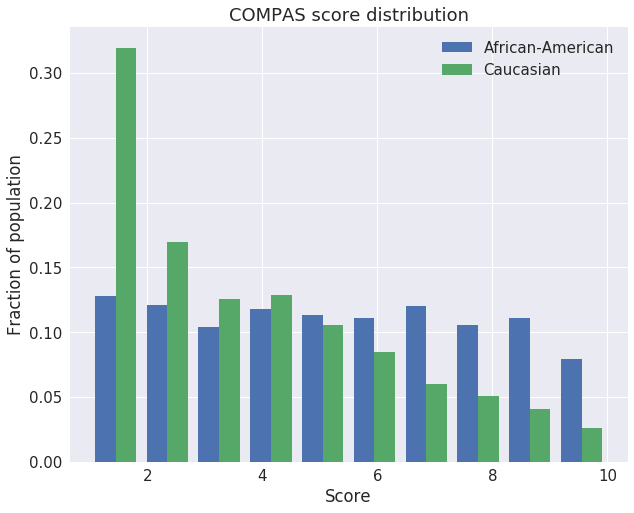

In [31]:
# now in visual form
x = df.loc[df['race']=='African-American','decile_score'].values
y = df.loc[df['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[10,8])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution')
plt.xlabel('Score')
plt.ylabel('Fraction of population')

As you can observe, there is a large discrepancy. Does this change when we condition on other random variables? Let's look at the distribution of scores for individuals with more than 2 priors.

/home/smb/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Fraction of population')

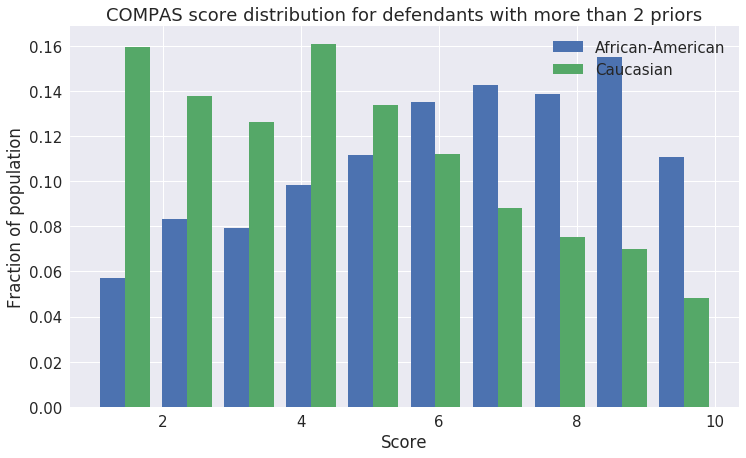

In [32]:
df_2priors = df.loc[df['priors_count']>=2]
x = df_2priors.loc[df_2priors['race']=='African-American','decile_score'].values
y = df_2priors.loc[df_2priors['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[12,7])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution for defendants with more than 2 priors')
plt.xlabel('Score')
plt.ylabel('Fraction of population')

Still a big difference.

### Question: How does the COMPAS score distribution change under different conditionings (e.g. degree charged, length of prison stay, etc.)? Does a Simpson's Paradox-like phenomenom happen?

/home/smb/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Fraction of population')

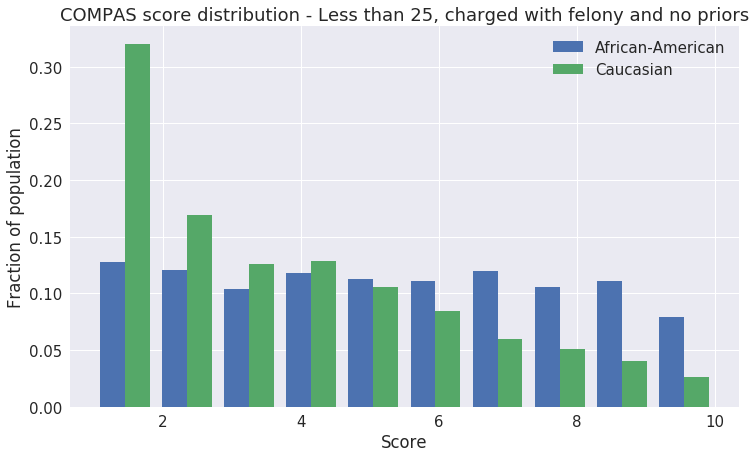

In [33]:
# hard to find... For example at young felons with no priors
df_ans = df.loc[(df['priors_count']==0)&(df['c_charge_degree']=='F')&df['age']<=25]
x = df_ans.loc[df_ans['race']=='African-American','decile_score'].values
y = df_ans.loc[df_ans['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[12,7])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution - Less than 25, charged with felony and no priors')
plt.xlabel('Score')
plt.ylabel('Fraction of population')

We quantize our dataset next to make the analysis a little bit easier.

In [34]:
dfQ = df.copy()

# Quantize priors count between 0, 1-3, and >3
def quantizePrior(x):
    if x <=0:
        return '0'
    elif 1<=x<=3:
        return '1 to 3'
    else:
        return 'More than 3'

    
# Quantize length of stay
def quantizeLOS(x):
    if x<= 7:
        return '<week'
    if 8<x<=93:
        return '<3months'
    else:
        return '>3 months'
    
# Quantize length of stay
def adjustAge(x):
    if x == '25 - 45':
        return '25 to 45'
    else:
        return x

# Quantize score_text to MediumHigh
def quantizeScore(x):
    if (x == 'High')| (x == 'Medium'):
        return 1
    else:
        return 0

    
dfQ['priors_count'] = dfQ['priors_count'].apply(quantizePrior)
dfQ['length_of_stay'] = dfQ['length_of_stay'].apply(quantizeLOS)
dfQ['score_text'] = dfQ['score_text'].apply(quantizeScore)
dfQ['age_cat'] = dfQ['age_cat'].apply(adjustAge)

Now we can look at the percentage difference of the average COMPAS scores between Caucasians and African-Americans for different groups. (**Important**: error bars omitted, so large differences may be due to limited samples)

Text(0.5,1,'Average COMPAS score percentage difference between\nCaucasian and African-American for different groups')

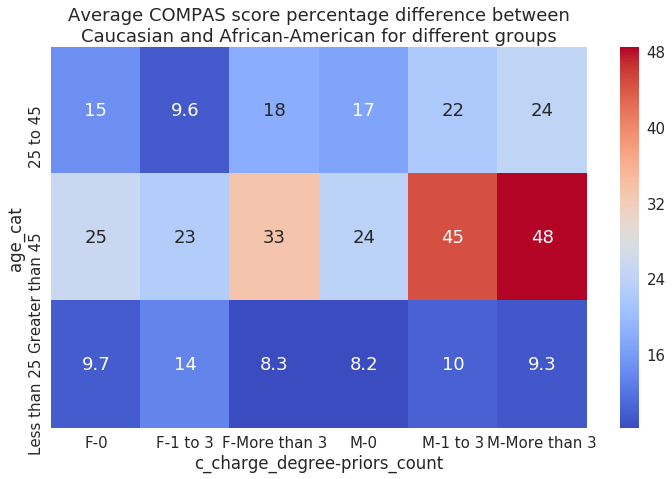

In [35]:
# African-american
dfPlot_AA = dfQ.loc[dfQ['race']=='African-American'].copy()
dfPlot_AA = dfPlot_AA.groupby(['age_cat','c_charge_degree','priors_count'])['decile_score'].mean().reset_index()
dfinal_AA = dfPlot_AA.pivot_table(index =['age_cat'],columns = ['c_charge_degree','priors_count'],values="decile_score")

# Caucasian
dfPlot_C = dfQ.loc[dfQ['race']=='Caucasian'].copy()
dfPlot_C = dfPlot_C.groupby(['age_cat','c_charge_degree','priors_count'])['decile_score'].mean().reset_index()
dfinal_C = dfPlot_C.pivot_table(index =['age_cat'],columns = ['c_charge_degree','priors_count'],values="decile_score")

plt.figure(figsize=[12,7])
sns.heatmap(100*(dfinal_AA.div(dfinal_C)-1),cmap="coolwarm",annot=True)
plt.title('Average COMPAS score percentage difference between\nCaucasian and African-American for different groups')

What's happening with the "greater than 45" group? Let's plot the score distribution for that group.

/home/smb/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Fraction of population')

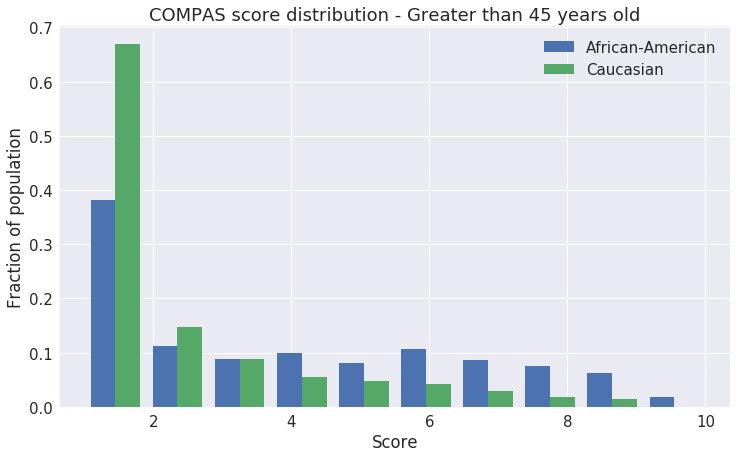

In [36]:
# hard to find... For example at young felons with no priors
df_g45 = df.loc[(df['age']>=45)]
x = df_g45.loc[df_g45['race']=='African-American','decile_score'].values
y = df_g45.loc[df_g45['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[12,7])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution - Greater than 45 years old')
plt.xlabel('Score')
plt.ylabel('Fraction of population')

## What happens when we take actual 2-year recidivism values into account? Are the predictions fair?

First, let's look at the correlation between the quantized score, the decile score and the actual recidivism.

In [37]:
# Correlation between COMPAS score and 2-year recidivism

# measure with high-low score
print(dfQ[['two_year_recid','score_text']].corr())

# measure with decile_score
print(dfQ[['two_year_recid','decile_score']].corr())

                two_year_recid  score_text
two_year_recid        1.000000    0.314698
score_text            0.314698    1.000000
                two_year_recid  decile_score
two_year_recid        1.000000      0.368193
decile_score          0.368193      1.000000


The correlation is not that high. Let's measure the disparate impact of the quantized COMPAS score ($\leq4$ is low, everything else is high) according to the EEOC rule that the values with "high" for each protected group should be within 80% of each other. Of course, the interpertation here is not the same, but it's a good starting point.

reference: https://en.wikipedia.org/wiki/Disparate_impact#The_80.25_rule

In [38]:
# The correlation is not that high. Let's measure the disparate impact according to the EEOC rule
means = dfQ.groupby(['score_text','race']).size().unstack()
means = means/means.sum()
print(means)
# compute disparte impact
AA_with_high_score = means.loc[1,'African-American']
C_with_high_score = means.loc[1,'Caucasian']
percentage_diff = 100*(AA_with_high_score/C_with_high_score -1)
print('Percentage difference: %f%%' %percentage_diff)

race        African-American  Caucasian
score_text                             
0                   0.423937   0.669044
1                   0.576063   0.330956
Percentage difference: 74.060413%


The percentage of African-Americans who receive a higher score is 74% higher than Caucasians, so the COMPAS algorithm seems to have a disparate impact based on this rule. How does this change when we apply the same rule with with the true two year recidivism instead of the quantized COMPAS score?

In [39]:
means = dfQ.groupby(['two_year_recid','race']).size().unstack()
means = means/means.sum()
print(means)
# compute disparte impact
AA_with_high_score = means.loc[1,'African-American']
C_with_high_score = means.loc[1,'Caucasian']
percentage_diff = 100*(AA_with_high_score/C_with_high_score -1)
print(percentage_diff)

race            African-American  Caucasian
two_year_recid                             
0                        0.47685    0.60913
1                        0.52315    0.39087
33.842289786769356


There is a difference in recidivism, but not as high as assigned by the COMPAS scores.

Now let's measure the difference in scores when we consider both the COMPAS output at true recidivism.

We will consider a few different metrics. Further explaination can be found in North Point's response to the ProPublica article, and also in Alexandra Chouldechova’s paper (listed above). The link for it is https://assets.documentcloud.org/documents/2998391/ProPublica-Commentary-Final-070616.pdf . The discussion on error rates and calibration also appear in both. 

We first look at a metric called *callibration*. For $Y$ indicating two year recidivism, $S_Q$ indicating score (0=low, 1=high medium), and $R$ indicating race, we measure
$$\mathsf{cal} \triangleq \frac{\mathbb{P}\left(Y=1\mid S_Q=s,R=\mbox{African-American} \right)}{\mathbb{P}\left(Y=1 \mid S_Q=s,R=\mbox{Caucasian} \right)},$$ for different scores $s$. Considering our quantized scores, we look at the calibration for $s=1$. 

In [40]:
# compute averages
dfAverage = dfQ.groupby(['race','score_text'])['two_year_recid'].mean().unstack()
print(dfAverage)

num = dfAverage.loc['African-American',1]
denom = dfAverage.loc['Caucasian',1]
cal = num/denom
calpercent = 100*(cal-1)
print('Calibration: %f' % cal)
print('Calibration in percentage: %f%%' % calpercent)

score_text               0         1
race                                
African-American  0.351412  0.649535
Caucasian         0.289979  0.594828
Calibration: 1.091972
Calibration in percentage: 9.197233%


The difference looks much smaller than before. The problem of the above calibration measure is that it depends on the threshold on which we quantized the scores $S_Q$. In order to mitigate this, let's look at a measure called *predictive parity.* In this example, we define predictive parity as
$$\mathsf{PP}(s) \triangleq \frac{\mathbb{P}\left(Y=1\mid S\geq s,R=\mbox{African-American} \right)}{\mathbb{P}\left(Y=1 \mid S\geq s,R=\mbox{Caucasian} \right)},$$
where $S$ is the original score.

We plot $\mathsf{PP}(s) $ for $s$ from 1 to 10. 

Text(0.5,1,'Predictive parity for different thresholds\n(warning: no error bars)')

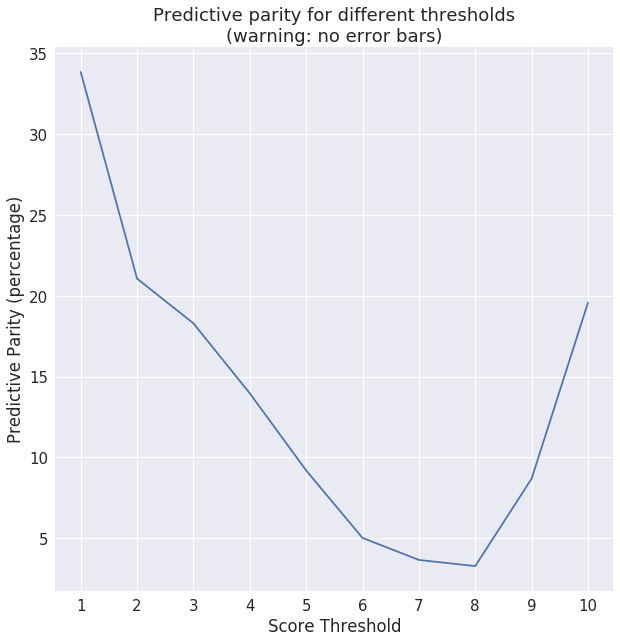

In [41]:
# aux function for thresh score
def threshScore(x,s):
    if x>=s:
        return 1
    else:
        return 0

ppv_values = []
dfP = dfQ[['race','two_year_recid']].copy()
for s in range(1,11):
    dfP['threshScore'] = dfQ['decile_score'].apply(lambda x: threshScore(x,s))
    dfAverage = dfP.groupby(['race','threshScore'])['two_year_recid'].mean().unstack()
    num = dfAverage.loc['African-American',1]
    denom = dfAverage.loc['Caucasian',1]
    ppv_values.append(100*(num/denom-1))


plt.figure(figsize=[10,10])
plt.plot(range(1,11),ppv_values)
plt.xticks(range(1,11))
plt.xlabel('Score Threshold')
plt.ylabel('Predictive Parity (percentage)')
plt.title('Predictive parity for different thresholds\n(warning: no error bars)')

Note how predictive parity depends significantly on the threshold.

We analyze next the difference in *error rates* between groups. First, we look at is the ROC for each group. We normalize the score between 0 and 1. The ROC thresholds produced by `scikitlearn` are the same.

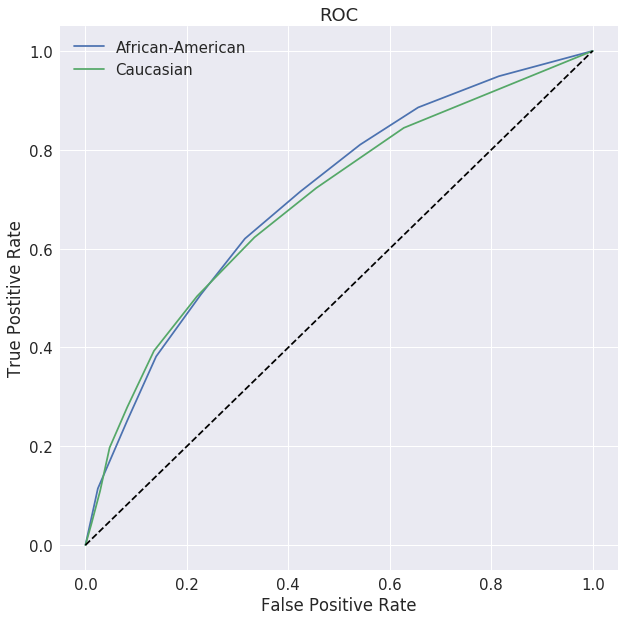

In [42]:
# normalize decile score
max_score = dfQ['decile_score'].max()
min_score = dfQ['decile_score'].min()
dfQ['norm_score'] = (dfQ['decile_score']-min_score)/(max_score-min_score)


plt.figure(figsize=[10,10])
#plot ROC curve for African-Americans
y = dfQ.loc[dfQ['race']=='African-American',['two_year_recid','norm_score']].values
fpr1,tpr1,thresh1 = roc_curve(y_true = y[:,0],y_score=y[:,1])
plt.plot(fpr1,tpr1)

#plot ROC curve for Caucasian
y = dfQ.loc[dfQ['race']=='Caucasian',['two_year_recid','norm_score']].values
fpr2,tpr2,thresh2 = roc_curve(y_true = y[:,0],y_score=y[:,1])
plt.plot(fpr2,tpr2)
l = np.linspace(0,1,10)
plt.plot(l,l,'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Postitive Rate')
plt.title('ROC')
plt.legend(['African-American','Caucasian'])


For each group, the point in the ROC curve corresponds to a $$(\mbox{false postive rate, true positive rate})$$ pair for a given threshold. In order to caputre the difference in error rates, we map the points to $$\left(\frac{\mbox{false postive rate Afr.-American}}{\mbox{false postive rate Cauc.}},s \right)$$
and similarly for *false negative* rates for different thersholds s.

Text(0.5,1,'Ratio between African-American and Caucasian error rates\n for different score thresholds')

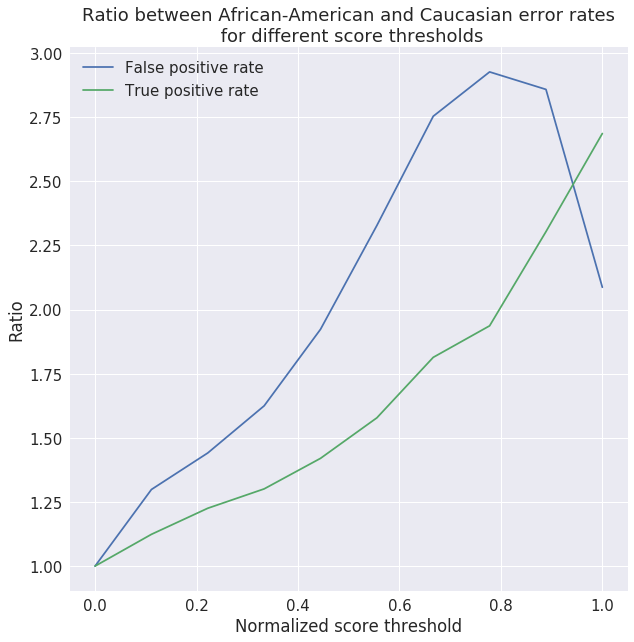

In [43]:
fpr_ratio = fpr1[1:]/fpr2[1:]
tpr_ratio = (tpr1[1:])/(tpr2[1:])
plt.figure(figsize=[10,10])
plt.plot(thresh1[1:],fpr_ratio)
plt.plot(thresh1[1:],tpr_ratio)
plt.xlabel('Normalized score threshold')
plt.ylabel('Ratio')

plt.legend(['False positive rate','True positive rate'])
plt.title('Ratio between African-American and Caucasian error rates\n for different score thresholds')

The difference is once again stark. This graph is particlarly concerning due to the significantly higher false positive rates for African Americans across all thresholds.